#### <font color='blue'>Install the packages necessary first</font>

In [ ]:
!pip install psycopg2-binary
!pip install seaborn

In [315]:
import boto3
import psycopg2
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.patches as mpatches

In [316]:
def print_psycopg2_exception(err):
    err_type, err_obj, traceback = sys.exc_info()
    line_num = traceback.tb_lineno
    print ("\npsycopg2 ERROR:", err, "on line number:", line_num)
    print ("psycopg2 traceback:", traceback, "-- type:", err_type)
    print ("\nextensions.Diagnostics:", err.diag)
    print ("pgerror:", err.pgerror)
    print ("pgcode:", err.pgcode, "\n")

#### <font color='blue'>Connect to PostgreSQL database</font>

In [317]:
conn = psycopg2.connect(database="YOUR_DATABASE", user='<YOUR_USER>', password='<YOUR_PASSWORD>', 
                        host='<DATABASE_HOST>', port= '5432')
cursor = conn.cursor()
cursor.execute("select now()")
data = cursor.fetchone()
print("Server Date: ", data)
print("\n")

Server Date:  (datetime.datetime(2023, 7, 18, 14, 49, 20, 232363, tzinfo=datetime.timezone.utc),)




In [318]:
curr_dt = datetime.now()
dt = curr_dt.strftime("%b_%d")
print(dt)

Jul_18


#### <font color='#B40085'>Query: For building Topic/Sentiment Charts (All Date Ranges)</font>

In [319]:
query = "SELECT a.message_date, a.primary_topic primary_topic, sum(a.senti_pos) positive, sum(a.senti_neg) negative, " 
query = query + "sum(a.senti_neu) neutral, sum(a.senti_mix) mixed "
query = query + "from ( "
query = query + "select message_date, primary_topic, "
query = query + "CASE sentiment WHEN 'POSITIVE' THEN 1 ELSE 0 end senti_pos, "
query = query + "CASE sentiment WHEN 'NEGATIVE' THEN 1 ELSE 0 end senti_neg, "
query = query + "CASE sentiment WHEN 'NEUTRAL' THEN 1 ELSE 0 end senti_neu, " 
query = query + "CASE sentiment WHEN 'MIXED' THEN 1 ELSE 0 end senti_mix "
query = query + "from ml_extract_track "
query = query + "where sentiment is not null and extract_status = 'C' ) a "
query = query + "group by a.message_date, a.primary_topic "
query = query + "order by 1,2; "
print(query)

try:
    cursor.execute(query)
    to_plot = cursor.fetchall()
    
except Exception as err:
    print_psycopg2_exception(err)
    conn.rollback()

df = pd.DataFrame(to_plot, columns=['message_date', 'primary_topic', 'positive', 'negative', 'neutral', 'mixed']).set_index('message_date')
print(df)
topic1_df = df[df.primary_topic == "1"]
# topic1_df.sort_values(by=['message_date'])
topic1_df.drop(columns=["primary_topic"], inplace=True)
print(topic1_df)

# conn.close()

SELECT a.message_date, a.primary_topic primary_topic, sum(a.senti_pos) positive, sum(a.senti_neg) negative, sum(a.senti_neu) neutral, sum(a.senti_mix) mixed from ( select message_date, primary_topic, CASE sentiment WHEN 'POSITIVE' THEN 1 ELSE 0 end senti_pos, CASE sentiment WHEN 'NEGATIVE' THEN 1 ELSE 0 end senti_neg, CASE sentiment WHEN 'NEUTRAL' THEN 1 ELSE 0 end senti_neu, CASE sentiment WHEN 'MIXED' THEN 1 ELSE 0 end senti_mix from ml_extract_track where sentiment is not null and extract_status = 'C' ) a group by a.message_date, a.primary_topic order by 1,2; 
             primary_topic  positive  negative  neutral  mixed
message_date                                                  
2015-01-09               5         0         0        3      0
2015-01-10               7         0         0        1      0
2015-01-10               8         0         0        1      0
2015-02-04               8         0         0        1      0
2015-03-30               7         0         0      

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### <font color='#B40085'>Query: For building Topic/Sentiment Charts (Dec. 2021 - Jun. 2023)</font>

In [324]:
query = "SELECT a.message_month, a.primary_topic primary_topic, sum(a.senti_pos) positive, sum(a.senti_neg) negative, " 
query = query + "sum(a.senti_neu) neutral, sum(a.senti_mix) mixed "
query = query + "FROM (SELECT TO_CHAR(message_date, 'YYYY-MM') message_month, primary_topic, "
query = query + "             CASE sentiment WHEN 'POSITIVE' THEN 1 ELSE 0 end senti_pos, "
query = query + "             CASE sentiment WHEN 'NEGATIVE' THEN 1 ELSE 0 end senti_neg, "
query = query + "             CASE sentiment WHEN 'NEUTRAL' THEN 1 ELSE 0 end senti_neu, " 
query = query + "             CASE sentiment WHEN 'MIXED' THEN 1 ELSE 0 end senti_mix "
query = query + "        FROM ml_extract_track "
query = query + "       WHERE sentiment IS NOT NULL AND extract_status = 'C' AND "
query = query + "             message_date > '2021-11-30' AND message_date < '2023-07-01' ) a "
query = query + "GROUP BY a.message_month, a.primary_topic "
query = query + "ORDER BY 1,2; "
print(query)

try:
    cursor.execute(query)
    to_plot = cursor.fetchall()
    
except Exception as err:
    print_psycopg2_exception(err)
    conn.rollback()

df = pd.DataFrame(to_plot, columns=['message_month', 'primary_topic', 'positive', 'negative', 'neutral', 'mixed']).set_index('message_month')
print(df)
topic1_df = df[df.primary_topic == "1"]
# topic1_df.sort_values(by=['message_date'])
topic1_df.drop(columns=["primary_topic"], inplace=True)
print(topic1_df)

# conn.close()

SELECT a.message_month, a.primary_topic primary_topic, sum(a.senti_pos) positive, sum(a.senti_neg) negative, sum(a.senti_neu) neutral, sum(a.senti_mix) mixed FROM (SELECT TO_CHAR(message_date, 'YYYY-MM') message_month, primary_topic,              CASE sentiment WHEN 'POSITIVE' THEN 1 ELSE 0 end senti_pos,              CASE sentiment WHEN 'NEGATIVE' THEN 1 ELSE 0 end senti_neg,              CASE sentiment WHEN 'NEUTRAL' THEN 1 ELSE 0 end senti_neu,              CASE sentiment WHEN 'MIXED' THEN 1 ELSE 0 end senti_mix         FROM ml_extract_track        WHERE sentiment IS NOT NULL AND extract_status = 'C' AND              message_date > '2021-11-30' AND message_date < '2023-07-01' ) a GROUP BY a.message_month, a.primary_topic ORDER BY 1,2; 
              primary_topic  positive  negative  neutral  mixed
message_month                                                  
2021-12                   1         1        12       23      1
2021-12                   2         1         3       34   

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### <font color='#B40085'> Query: For Topic by message_date Charts (for all date range)

In [321]:
topic_query = "select message_date, primary_topic, count(*) msg_cnt from ml_extract_track where extract_status = 'C' " 
topic_query = topic_query + "group by message_date, primary_topic;" 
print(topic_query)

try:
    cursor.execute(topic_query)
    topic_data = cursor.fetchall()
    
except Exception as err:
    print_psycopg2_exception(err)
    conn.rollback()

topic_df = pd.DataFrame(topic_data, columns=['message_date', 'primary_topic', 'msg_cnt']).set_index('message_date')
print(topic_df)


select message_date, primary_topic, count(*) msg_cnt from ml_extract_track where extract_status = 'C' group by message_date, primary_topic;
             primary_topic  msg_cnt
message_date                       
2022-11-15               6        1
2022-05-26               1        6
2022-07-06               2        5
2022-02-02               2       12
2022-01-24               4       17
...                    ...      ...
2022-05-11               8        1
2021-12-20               7        1
2022-06-24               5        3
2022-04-22               6        2
2023-04-21               7        4

[2414 rows x 2 columns]


#### <font color='#B40085'>Query: For Topic Charts by YYYY-MM (Jan 2021 - June 2023)

In [322]:
topic_query = "SELECT TO_CHAR(message_date, 'YYYY-MM') msg_yr_mth, primary_topic, COUNT(*) msg_cnt FROM ml_extract_track "
topic_query = topic_query + "WHERE extract_status = 'C' AND message_date > '2021-11-30' AND message_date < '2023-07-01' AND "
topic_query = topic_query + "primary_topic IS NOT NULL "
topic_query = topic_query + "GROUP BY TO_CHAR(message_date, 'YYYY-MM'), primary_topic ORDER BY 1; " 
print(topic_query)

try:
    cursor.execute(topic_query)
    topic_data = cursor.fetchall()
    
except Exception as err:
    print_psycopg2_exception(err)
    conn.rollback()

topics_df = pd.DataFrame(topic_data, columns=['msg_yr_mth', 'primary_topic', 'msg_cnt']).set_index('msg_yr_mth')
print(topics_df)q

SELECT TO_CHAR(message_date, 'YYYY-MM') msg_yr_mth, primary_topic, COUNT(*) msg_cnt FROM ml_extract_track WHERE extract_status = 'C' AND message_date > '2021-11-30' AND message_date < '2023-07-01' AND primary_topic IS NOT NULL GROUP BY TO_CHAR(message_date, 'YYYY-MM'), primary_topic ORDER BY 1; 
           primary_topic  msg_cnt
msg_yr_mth                       
2021-12                5       18
2021-12                2       39
2021-12                3       20
2021-12                4       13
2021-12                7       26
...                  ...      ...
2023-06                6       15
2023-06                8       10
2023-06                3       14
2023-06                4       15
2023-06                1       56

[151 rows x 2 columns]


#### <font color='#000099'>Line Chart: Plot all the four sentiments in the same chart

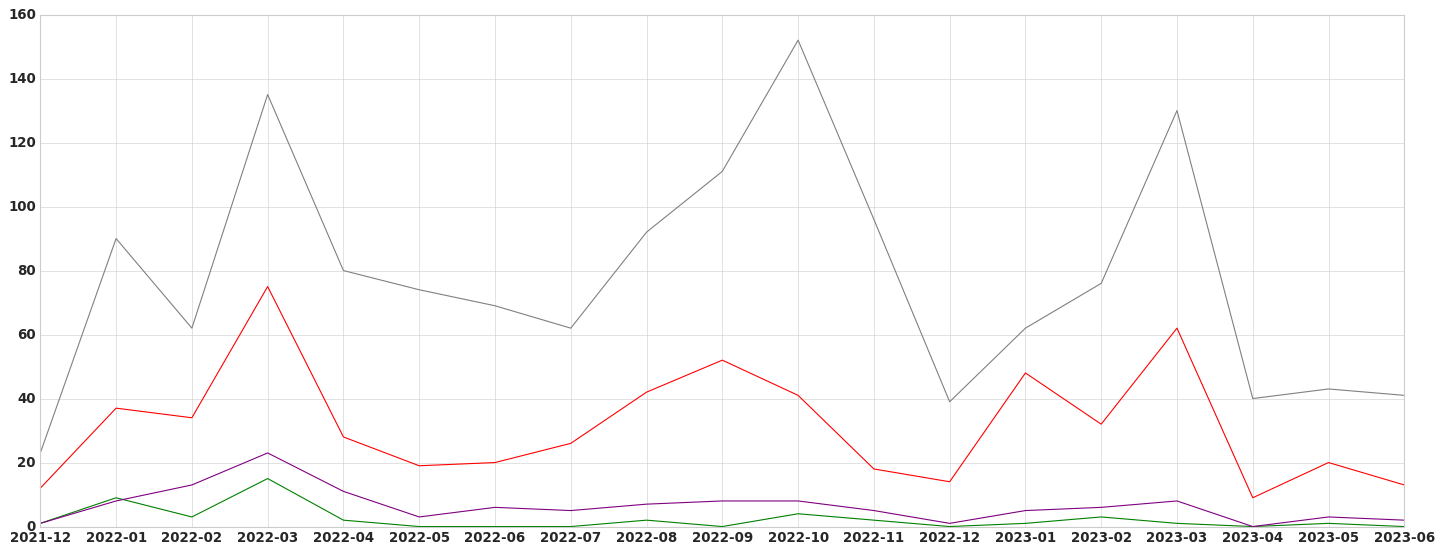

In [325]:
# topic1_df.plot(subplots=True, legend=True)
# plt.plot(topic1_df.index, topic1_df['positive'])

plt.figure(figsize=(22,8))
for col in ['positive', 'negative', 'neutral', 'mixed']:
    
    if col == 'negative':
        # plt.plot(topic1_df.index, topic1_df[col])
        plt.plot(topic1_df.index, topic1_df[col], color='red', linewidth=1)
        # plt.plot(topic1_df.index, topic1_df[col], color='red', marker='o', markerfacecolor='yellow', markeredgecolor='blue', markersize=3)
    
    if col == 'positive':
        # plt.plot(topic1_df.index, topic1_df[col])
        plt.plot(topic1_df.index, topic1_df[col], color='green', linewidth=1)
        # plt.plot(topic1_df.index, topic1_df[col], color='green', marker='o', markerfacecolor='yellow', markeredgecolor='blue', markersize=3)
    
    if col == 'neutral':
        # plt.plot(topic1_df.index, topic1_df[col])
        plt.plot(topic1_df.index, topic1_df[col], color='grey', linewidth=1)
        # plt.plot(topic1_df.index, topic1_df[col], color='green', marker='o', markerfacecolor='yellow', markeredgecolor='blue', markersize=3)
    
    if col == 'mixed':
        # plt.plot(topic1_df.index, topic1_df[col])
        plt.plot(topic1_df.index, topic1_df[col], color='purple', linewidth=1)
        # plt.plot(topic1_df.index, topic1_df[col], color='green', marker='o', markerfacecolor='yellow', markeredgecolor='blue', markersize=3)
        plt.show()

#### <font color='#000099'>Line Chart: Sentiments in individual graph (manually run one-by-one)

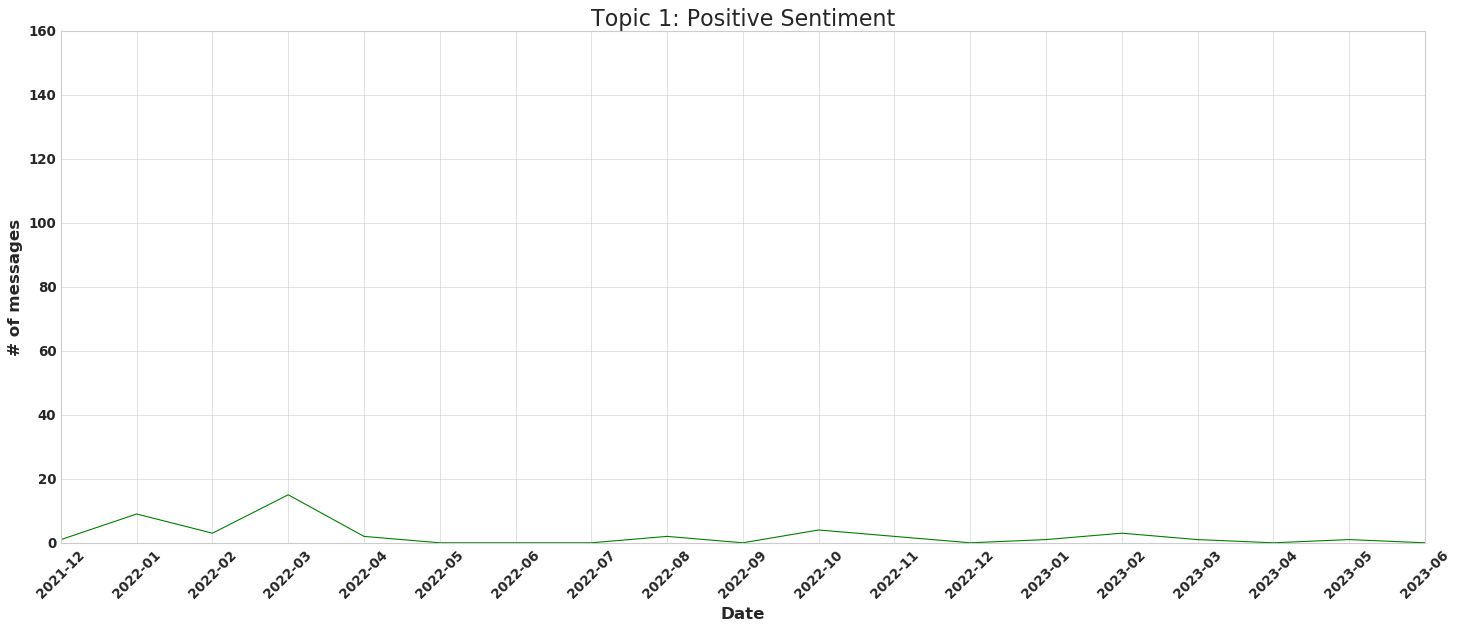

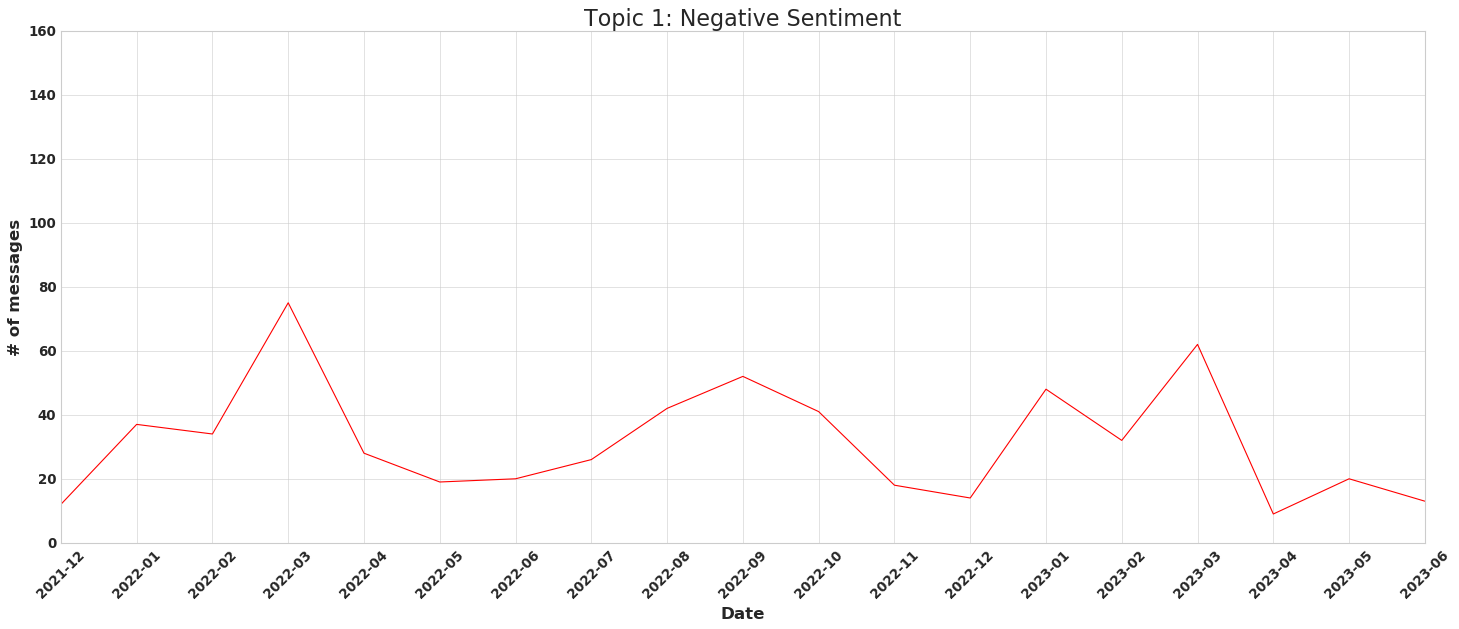

In [333]:
fig, ax = plt.subplots(figsize=(22, 8))
plt.plot(topic1_df.index, topic1_df['positive'], color='green')
plt.title('Topic 1: Positive Sentiment', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('# of messages', fontsize=15)
plt.ylim(0, 160)
plt.xlim(topic1_df.index.min(), topic1_df.index.max())
plt.gca().xaxis.set_tick_params(rotation = 45)
# ticks = list(topic1_df.index)
# plt.xticks(ticks, rotation=45)
# Formatting time axis tick labels
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
# plt.savefig('/root/charts/positive.png')
plt.show()

fig, ax = plt.subplots(figsize=(22, 8))
plt.plot(topic1_df.index, topic1_df['negative'], color='red')
plt.title('Topic 1: Negative Sentiment', fontsize=20)
plt.xlabel('Date', fontsize=15)
plt.ylabel('# of messages', fontsize=15)
plt.ylim(0, 160)
plt.xlim(topic1_df.index.min(), topic1_df.index.max())
plt.gca().xaxis.set_tick_params(rotation = 45)
# ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
# plt.savefig('/root/charts/negative.png')
plt.show()

#### <font color='#000099'>To check the name of the styles available

In [ ]:
print(plt.style.available)

#### <font color='#000099'>Line Plot: Individual Charts for Topics (Y Axis not scaled)

In [ ]:
colors = [ 'black', 'purple', 'red', 'blue', 'green', 'grey', 'orange', 'cyan' ] 
topics = [ '1', '2', '3', '4', '5', '6', '7', '8' ]
topic_desc = ["Topic 1: Account Login, Password, Lock & Reset", 
              "Topic 2: Account Manager Authorization, Representative/Sponsor Reassignments", 
              "Topic 3: Application/Plan Submission, Annual Deadline/Approval", 
              "Topic 4: Reconciliation Steps, Completion, Processing and Finalization", 
              "Topic 5: Information, Contact, Additional Overpayment Inquiries", 
              "Topic 6: Cost Report, Vendor Option, Benefit Adjustment", 
              "Topic 7: Retiree File Management, Response, List, Upload, Notification", 
              "Topic 8: Support Request, Payment, Program, Application Resolution"]
cnt = 0
# fig, ax = plt.subplots(figsize=(22,8))
for topic_no in topics:
    # if topic_no > '3': 
        # cnt += 1
        # continue
    topic_df = topics_df[topics_df.primary_topic == topic_no]
    topic_df.drop(columns=["primary_topic"], inplace=True)
    fig, ax = plt.subplots(figsize=(22,8))
    plt.style.use('seaborn-whitegrid')
    plt.plot(topic_df.index, topic_df['msg_cnt'], color=colors[cnt], label='Topic'+str(cnt+1))
    # plt.stackplot(topic_df.index, topic_df['msg_cnt'])
    # plt.title('All Topics in one graph', fontsize=18, fontweight='bold')
    plt.title(topic_desc[cnt] + ' (Messages Over Time)', fontsize=18, fontweight='bold')
    plt.xlabel('Date Range', fontsize=12, fontweight='bold')
    plt.ylabel('# of messages', fontsize=14, fontweight='bold')
    plt.ylim(1, 320)
    plt.xlim(topic_df.index.min(), topic_df.index.max())
    plt.gca().xaxis.set_tick_params(rotation = 45)
    plt.legend(framealpha=1, frameon=True, fancybox=True, shadow=True, borderpad=1)
    
    # ax.set_xticklabels(ax.get_xticks(), weight='bold', size=11)
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
    # filename = "/root/charts/topic" + topic_no + "_timeseries_" + dt + ".png"
    # print('topic#:', topic_desc[cnt], ' color:', colors[cnt], ' filename:', filename)
    # input("press return to continue..")
    # plt.savefig(filename)
    plt.show()
    cnt += 1
# filename = "/root/charts/all_topics_" + dt + ".png"
# plt.savefig(filename)
# plt.show()

#### <font color='#000099'>Line Plot: All Topics in one Chart for Dec. 2021 - Jun. 2023 (Y Axis scaled)

In [ ]:
# colors = [ '#00001A', '#A40000', '#2929FF', '#00A400', '#9B09FF', '#7A7AA6', '#D27D00', '#1DD4FF' ] 
colors = [ 'black', 'purple', 'brown', 'blue', 'orange', 'grey', 'green', '#00F8F2' ] 
topics = [ '1', '2', '3', '4', '5', '6', '7', '8' ]
topic_desc = ["Topic 1: Account Login, Password, Lock & Reset", 
              "Topic 2: Account Manager Authorization, Representative/Sponsor Reassignments", 
              "Topic 3: Application/Plan Submission, Annual Deadline/Approval", 
              "Topic 4: Reconciliation Steps, Completion, Processing and Finalization", 
              "Topic 5: Information, Contact, Additional Overpayment Inquiries", 
              "Topic 6: Cost Report, Vendor Option, Benefit Adjustment", 
              "Topic 7: Retiree File Management, Response, List, Upload, Notification", 
              "Topic 8: Support Request, Payment, Program, Application Resolution"]
cnt = 0
# fig, ax = plt.subplots(figsize=(22,8))
plt.figure(figsize=(22,8))
plt.style.use('seaborn-whitegrid')
plt.xlabel('Date Range', fontsize=12, fontweight='bold')
plt.ylabel('# of messages', fontsize=14, fontweight='bold')
plt.title("All Topics for the same date range", fontsize=18, fontweight='bold')
plt.gca().xaxis.set_tick_params(rotation = 45)
legend_properties = {'weight':'normal'}
plt.ylim(1, 320)
for topic_no in topics:
    # if topic_no > '3': 
        # cnt += 1
        # continue
    topic_df = topics_df[topics_df.primary_topic == topic_no]
    topic_df.drop(columns=["primary_topic"], inplace=True)
    # fig, ax = plt.subplots(figsize=(22,8))
    plt.plot(topic_df.index, topic_df['msg_cnt'], color=colors[cnt], label='Topic '+str(cnt+1))
    # plt.title(topic_desc[cnt] + ' (Messages Over Time)', fontsize=18, fontweight='bold')
    plt.xlim(topic_df.index.min(), topic_df.index.max())
    plt.legend(framealpha=0.9, frameon=True, fancybox=True, shadow=True, borderpad=1, prop=legend_properties)
    # ax.set_xticklabels(ax.get_xticks(), weight='bold', size=11)
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
    # filename = "/root/charts/topic" + topic_no + "_timeseries_" + dt + ".png"
    # print('topic#:', topic_desc[cnt], ' color:', colors[cnt], ' filename:', filename)
    # input("press return to continue..")
    # plt.savefig(filename)
    # plt.show()
    cnt += 1
# filename = "/root/charts/all_topics_" + dt + ".png"
# plt.savefig(filename)
plt.show()

#### <font color='#000099'>Stack Plot: Topics in individual charts for Dec. 2021 - Jun. 2023 (Y Axis scaled)

In [ ]:

colors = [ '#808080', '#B800B8', '#5D5DFF', '#8BFF8B', '#9B09FF', '#7A7AA6', '#D27D00', '#1DD4FF' ] 
# colors = [ 'black', 'purple', 'brown', 'blue', 'orange', 'grey', 'green', '#00F8F2' ] 
topics = [ '1', '2', '3', '4', '5', '6', '7', '8' ]
topic_short_desc = ["Topic 1: Account Login, Password, Lock", 
              "Topic 2: Acct Mgr. Auth, Rep Reassignment", 
              "Topic 3: Appl/Plan Submission, Annual Deadline", 
              "Topic 4: Reconciliation Processing/Finalization", 
              "Topic 5: Information, Contact, Addl Overpayment Inq", 
              "Topic 6: Cost Report, Vendor Option", 
              "Topic 7: Retiree File Management, Response", 
              "Topic 8: Support Request, Payment, Program"]

topic_desc = ["Topic 1: Account Login, Password, Lock & Reset", 
              "Topic 2: Account Manager Authorization, Representative/Sponsor Reassignments", 
              "Topic 3: Application/Plan Submission, Annual Deadline/Approval", 
              "Topic 4: Reconciliation Steps, Completion, Processing and Finalization", 
              "Topic 5: Information, Contact, Additional Overpayment Inquiries", 
              "Topic 6: Cost Report, Vendor Option, Benefit Adjustment", 
              "Topic 7: Retiree File Management, Response, List, Upload, Notification", 
              "Topic 8: Support Request, Payment, Program, Application Resolution"]
legend_patch = []
cnt = 0
plt.style.use('seaborn-pastel')
# fig, ax = plt.subplots(figsize=(22,8))

for topic_no in topics:
    # if topic_no > '4': 
        # cnt += 1
        # continue
    topic_df = topics_df[topics_df.primary_topic == topic_no]
    topic_df.drop(columns=["primary_topic"], inplace=True)
    plt.figure(figsize=(22,8))
    plt.xlabel('Date Range', fontsize=12, fontweight='bold')
    plt.ylabel('# of messages', fontsize=14, fontweight='bold')
    plt.gca().xaxis.set_tick_params(rotation = 45)
    plt.ylim(1, 320)
    plt.stackplot(topic_df.index, topic_df['msg_cnt'], color=colors[cnt], edgecolor='yellow')
    plt.title(topic_desc[cnt] + ' (Messages Over Time)', fontsize=18, fontweight='bold')
    plt.xlim(topic_df.index.min(), topic_df.index.max())
    # legend_patch.append(mpatches.Patch(color=colors[cnt], label=topic_short_desc[cnt]))
    # plt.legend(handles=legend_patch, loc="upper right", fontsize='medium')
    # plt.legend(framealpha=0.9, frameon=True, fancybox=True, shadow=True, borderpad=1, prop=legend_properties)
    # ax.set_xticklabels(ax.get_xticks(), weight='bold', size=11)
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
    # filename = "/root/charts/topic" + topic_no + "_timeseries_" + dt + ".png"
    # print('topic#:', topic_desc[cnt], ' color:', colors[cnt], ' filename:', filename)
    # input("press return to continue..")
    # plt.savefig(filename)
    plt.show()
    cnt += 1


#### <font color='#000099'>Stack Plot: All Topics (1-4 & 5-8) in one chart for Dec. 2021 - Jun. 2023 (Y Axis scaled)

In [ ]:
colors = [ '#808080', '#B800B8', '#5D5DFF', '#8BFF8B', '#9B09FF', '#7A7AA6', '#D27D00', '#1DD4FF' ] 
# colors = [ 'black', 'purple', 'brown', 'blue', 'orange', 'grey', 'green', '#00F8F2' ] 
topics = [ '1', '2', '3', '4', '5', '6', '7', '8' ]
topic_short_desc = ["Topic 1: Account Login, Password, Lock", 
              "Topic 2: Acct Mgr. Auth, Rep Reassignment", 
              "Topic 3: Appl/Plan Submission, Annual Deadline", 
              "Topic 4: Reconciliation Processing/Finalization", 
              "Topic 5: Information, Contact, Addl Overpayment Inq", 
              "Topic 6: Cost Report, Vendor Option", 
              "Topic 7: Retiree File Management, Response", 
              "Topic 8: Support Request, Payment, Program"]
topic_desc = ["Topic 1: Account Login, Password, Lock & Reset", 
              "Topic 2: Account Manager Authorization, Representative/Sponsor Reassignments", 
              "Topic 3: Application/Plan Submission, Annual Deadline/Approval", 
              "Topic 4: Reconciliation Steps, Completion, Processing and Finalization", 
              "Topic 5: Information, Contact, Additional Overpayment Inquiries", 
              "Topic 6: Cost Report, Vendor Option, Benefit Adjustment", 
              "Topic 7: Retiree File Management, Response, List, Upload, Notification", 
              "Topic 8: Support Request, Payment, Program, Application Resolution"]
legend_patch = []
cnt = 0
plt.style.use('seaborn-pastel')
# fig, ax = plt.subplots(figsize=(22,8))
plt.figure(figsize=(22,8))
plt.xlabel('Date Range', fontsize=12, fontweight='bold')
plt.ylabel('# of messages', fontsize=14, fontweight='bold')
plt.gca().xaxis.set_tick_params(rotation = 45)
plt.ylim(1, 320)

for topic_no in topics:
    if topic_no > '4': 
        cnt += 1
        continue
    topic_df = topics_df[topics_df.primary_topic == topic_no]
    topic_df.drop(columns=["primary_topic"], inplace=True)
    plt.stackplot(topic_df.index, topic_df['msg_cnt'], color=colors[cnt], edgecolor='yellow')
    # ax.title(topic_desc[cnt] + ' (Messages Over Time)', fontsize=18, fontweight='bold')
    plt.xlim(topic_df.index.min(), topic_df.index.max())
    legend_patch.append(mpatches.Patch(color=colors[cnt], label=topic_short_desc[cnt]))    
    # plt.legend(framealpha=0.9, frameon=True, fancybox=True, shadow=True, borderpad=1, prop=legend_properties)
    # ax.set_xticklabels(ax.get_xticks(), weight='bold', size=11)
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
    # filename = "/root/charts/topic" + topic_no + "_timeseries_" + dt + ".png"
    # print('topic#:', topic_desc[cnt], ' color:', colors[cnt], ' filename:', filename)
    # input("press return to continue..")
    # plt.savefig(filename)
    # plt.show()
    cnt += 1
filename = "/root/charts/topics_1_4_" + dt + ".png"
plt.savefig(filename, bbox_inches='tight')
plt.legend(handles=legend_patch, loc="upper right", fontsize='medium')
plt.show()

#### <font color='#000099'>Scatter Plot: Topics in individual chart for Dec. 2021 - Jun. 2023 (Y Axis scaled)

In [ ]:
colors = [ 'black', 'brown', 'purple', 'blue', 'green', 'grey', 'orange', 'cyan' ] 
topics = [ '1', '2', '3', '4', '5', '6', '7', '8' ]
topic_desc = ["Topic 1: Account Login, Password, Lock & Reset", 
              "Topic 2: Account Manager Authorization, Representative/Sponsor Reassignments", 
              "Topic 3: Application/Plan Submission, Annual Deadline/Approval", 
              "Topic 4: Reconciliation Steps, Completion, Processing and Finalization", 
              "Topic 5: Information, Contact, Additional Overpayment Inquiries", 
              "Topic 6: Cost Report, Vendor Option, Benefit Adjustment", 
              "Topic 7: Retiree File Management, Response, List, Upload, Notification", 
              "Topic 8: Support Request, Payment, Program, Application Resolution"]
cnt = 0
for topic_no in topics:
    # if topic_no != '5': 
        # cnt += 1
        # continue
    topic_df = topics_df[topics_df.primary_topic == topic_no]
    topic_df.drop(columns=["primary_topic"], inplace=True)
    plt.figure(figsize=(22,8))
    # fig, ax = plt.subplots(figsize=(22,8))
    plt.ylim(1, 320)
    plt.scatter(topic_df.index, topic_df['msg_cnt'], s=50, c=colors[cnt], alpha=0.5, marker ="s", linewidths = 2)
    plt.title(topic_desc[cnt], fontsize=18, fontweight='bold')
    plt.xlabel('Date Range', fontsize=12, fontweight='bold')
    plt.ylabel('# of messages', fontsize=14, fontweight='bold')
    plt.xlim(topic_df.index.min(), topic_df.index.max())
    # plt.xlim('2021-11', '2023-07')
    plt.gca().xaxis.set_tick_params(rotation = 45)  
    plt.grid()
    '''
    plt.plot(topic_df.index, topic_df['msg_cnt'], color=colors[cnt])
    plt.ylim(1, 320)
    
    # ax.set_xticklabels(ax.get_xticks(), weight='bold', size=11)
    # ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%Y-%m'))
    filename = "/root/charts/topic" + topic_no + "_timeseries_" + dt + ".png"
    print('topic#:', topic_desc[cnt], ' color:', colors[cnt], ' filename:', filename)
    input("press return to continue..")
    plt.savefig(filename)
    '''
    plt.show()
    cnt += 1